# Random forest model

This notebook first runs the best attack/no-attack model (random forest) and then
runs a second random forest on the rows labeled as attacks to categorize them.
This gives the total of 10 labels. 

The multi-classification step gets tricky because I didn't want to use the default
BalancedRandomForestClassifier for 9 so badly unbalanced remaining labels. 

There are still a lot of hyperparameters hiding in the resampling strategy that could
be further tuned, but getting the labels right for the labels with few training examples 
is probably hopeless.

In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, make_scorer
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample 
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn import FunctionSampler

from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting.remove_chartjunk import remove_borders

from consistent_labels import get_attack_labels
from data_read import data_read

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
%load_ext watermark
%watermark -iv -p sklearn,mlxtend,imblearn

matplotlib 3.0.2
numpy      1.15.4
pandas     0.24.0
sklearn 0.20.2
mlxtend 0.15.0.0
imblearn 0.4.3


# Scoring function 

The balanced_accuracy_score, adjusted for beating random with unbalanced classes 
is my optimization target.

In [3]:
acc_scoring = make_scorer(balanced_accuracy_score, adjusted=True)

# Attack-no-attack model

The best random forest from the attack/no-attack case

In [4]:
df = data_read('train', 'fixed')

In [5]:
# The data is so imbalanced, we can 
# throw out half the normal data with no loss of 
# model quality, makes notebook run faster
normal = df.query('label == 0')
rows = normal.shape[0]
rows //= 2
half_normal = resample(normal, replace=False, n_samples=rows )

attack = df.query('label == 1')
df = pd.concat([attack, half_normal], axis=0)
df.shape

(858402, 39)

In [6]:
y = df.label
X = df.drop(columns=['label','attack_cat'])

In [7]:
y.value_counts()

0    665628
1    192774
Name: label, dtype: int64

In [8]:
# Grid search was in the first RandomForest notebook
oneclassmodel = BalancedRandomForestClassifier( 
                            n_estimators=200,
                            max_features=8,
                            oob_score=True,
                            n_jobs=-1,  
                            random_state=5,
                            replacement=True)

oneclassmodel.fit(X, y)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features=8,
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                oob_score=True, random_state=5, replacement=True,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [9]:
## Quick check to make sure I got the same answer

In [10]:
test = data_read('test', 'fixed').drop(columns='attack_cat')
    
y_pred = oneclassmodel.predict( test.drop(columns='label') )
roc = roc_auc_score( test.label, y_pred ) 
acc = balanced_accuracy_score(test.label, y_pred, adjusted=True) 
print('roc = ', roc)
print('acc = ', acc)

roc =  0.993334327597557
acc =  0.986668655195114


[[875921  11583]
 [    36 128473]]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ab79635c0>)

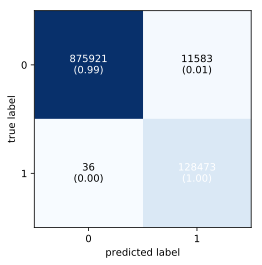

In [11]:
cm = confusion_matrix(test.label, y_pred)
print(cm)
plot_confusion_matrix(cm, show_absolute=True, show_normed=True)

# Now to label the attacks

Stacking on the one-class model that did so well will make sure
that giving the model more choices won't make it forget the good
stuff it already knows. We don't want to lose that near-perfect
recall! 

TODO: Could also pull out generic attacks (the most oversized label) as
a second yes/no model before trying to label.

TODO: Within the custom resampler, I could try some other resampling (SMOTENC) options instead of 
random resampling for the classes I'm struggling to distinguish (particularly 6,7 
which have smallest row counts)

In [12]:
def my_resampler(X, y):
    """
    Resampler function for imblearn pipeline: I'm using a custom resampler that downsamples the
    majority class and upsamples the minority classes using heuristics based around the number of 
    samples in the median-sized class. 
    The default imblearn sampling strategies are upsample OR downsample, but for this particular
    dataset I want to do a little of both.
    
    Takes: X,y ndarrays used by an imblearn sampler
    Returns: X,y resampled
    """
    
    df = pd.DataFrame(data=np.hstack([y.reshape(-1,1),X]))
    
    value_counts = df.iloc[:,0].value_counts()
    target_size = int(value_counts.median())
    max_increase = 30
    
    dfs = []
    for label,count in zip(value_counts.index,value_counts.values):
        rows = (df.iloc[:,0] == label)
        subset = df.loc[rows,:]
        
        if count < target_size:
            new_size = target_size
            
            # don't increase by more than max_increase times (worms!)
            if (new_size / count) > max_increase:
                new_size = count * max_increase
                
            subset = resample(subset, 
                              n_samples=new_size, 
                              replace=True)
        else:
            subset = resample(subset,
                             n_samples=target_size,
                             replace=True)
        dfs.append(subset)
        
    new_df = pd.concat(dfs, axis=0, ignore_index=True)
    
    return new_df.iloc[:,1:].values, new_df.iloc[:,0].values.reshape(-1)
        
    

# Set up the training data for the 9-class case 

We're dropping all the normal traffic now

In [13]:
# get the same labels used in all model notebooks
# they're also sorted by frequency this way
df = data_read('train', 'fixed')
encoder = get_attack_labels()
df.attack_cat = df.attack_cat.map(encoder)

In [14]:
y10 = df.attack_cat
y1 = df.label
X = df.drop(columns=['label', 'attack_cat'])

In [15]:
keep_rows = (y1 == 1) 
drop_rows = (y1 == 0)

In [16]:
X2 = X.loc[keep_rows, :]
y2 = y10[keep_rows]

In [17]:
X2.shape, y2.shape

((192774, 37), (192774,))

In [18]:
y2.value_counts()

1    129289
2     26715
3     14548
4      9812
5      8393
6      1607
7      1398
8       907
9       105
Name: attack_cat, dtype: int64

In [19]:
pipe = imb_make_pipeline(
    FunctionSampler(my_resampler),
    DecisionTreeClassifier(max_depth=7) 
            # TODO: baggingclassifier class doesn't take keywords for grid searching
            # on the base_estimator hyperparameters. I'm definitely getting better results
            # by resampling on each tree than once per forest, but grid searching is a pain
            # need to decompose the pipeline one more time via manual cross_val_score calls
            # and properly tune my trees
)
    
n_estimators = [ 300 ] 
max_features = [ 16 ] 

param_grid = {
    'n_estimators':n_estimators,
    'max_features':max_features,
}
clf = BaggingClassifier( base_estimator=pipe,
                        n_jobs=-1,
                        random_state=5,
                        bootstrap=False # The bootstrap will be done in my_resampler
                       )
    
best = GridSearchCV( clf,
                  param_grid,
                  scoring = acc_scoring,
                  cv = 3,
                  verbose = True,
                  return_train_score = False
                  )
    
best = best.fit(X2, y2)
pd.DataFrame(best.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   54.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,16.955663,1.294984,1.062426,0.007144,16,300,"{'max_features': 16, 'n_estimators': 300}",0.587275,0.600179,0.604677,0.597377,0.007375,1


In [20]:
y_pred = best.predict(X2)
cm = confusion_matrix(y2, y_pred)
pd.DataFrame(cm, index=best.best_estimator_.classes_, columns=best.best_estimator_.classes_)

,1,2,3,4,5,6,7,8,9
1,125691,1412,396,682,32,58,382,618,18
2,5,12163,1354,5808,1249,434,3547,1304,851
3,14,54,11604,662,263,58,925,946,22
4,0,1292,251,4622,132,166,2765,507,77
5,0,23,129,703,6719,15,500,268,36
6,0,13,1,643,5,400,541,4,0
7,0,33,21,508,19,6,763,36,12
8,0,0,17,0,72,0,0,818,0
9,0,1,2,0,0,1,0,17,84


# Now test our two-step model 

In [21]:
df = data_read('test', 'fixed')

X_test = df.drop(columns=['attack_cat','label'])
y1_test = df.label
y10_test = df.attack_cat.map(encoder)

In [22]:
# First, run it through the one-class classifier
y_pred = oneclassmodel.predict(X_test)

In [23]:
# Then take only those labeled as attacks through the attack label classifier
keep_rows = (y_pred == 1)
drop_rows = (y_pred == 0)

In [24]:
y10_subset_test = y10_test[keep_rows]
X10_subset_test = X_test.loc[keep_rows,:]

y_pred10 = best.predict( X10_subset_test )

In [25]:
y_pred10 = pd.Series(y_pred10)

In [26]:
# Now we need to assemble the original data set to see how we did! a
# concatenate the stuff we dropped with the stuff we got back from the second model

In [27]:
X_test_full = np.vstack([X_test.loc[drop_rows, :], X10_subset_test])
y_test_full = np.hstack([y10_test[drop_rows].values, y10_subset_test])
y_pred_full = np.hstack([y_pred[drop_rows], y_pred10])

In [28]:
mat = matthews_corrcoef( y_test_full, y_pred_full )
acc = balanced_accuracy_score( y_test_full, y_pred_full,
                                       adjusted=True )

In [29]:
mat, acc

(0.8701827156263388, 0.6503312820157147)

In [30]:
cm = confusion_matrix(y_test_full, y_pred_full)
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9
0,875921,12,168,8987,12,334,1298,16,755,1
1,1,83834,932,261,451,20,46,247,383,17
2,5,4,7976,901,3930,867,255,2429,888,555
3,22,14,44,7710,467,199,44,560,626,12
4,0,1,897,165,2990,97,108,1883,347,53
5,0,1,29,87,482,4409,8,381,178,19
6,8,0,5,1,433,2,233,381,7,0
7,0,0,19,14,368,22,24,449,29,6
8,0,0,0,16,0,57,0,0,531,0
9,0,0,3,3,0,0,0,0,6,57


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2e543940>)

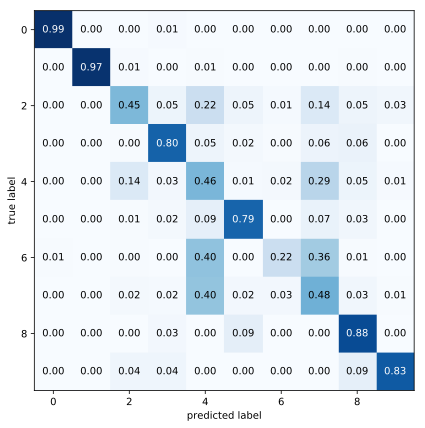

In [31]:
plot_confusion_matrix(cm, show_absolute=False, show_normed=True, figsize=(7,7))

In [32]:
# save the confusion matrix for making a prettier plot for slides
cmdf = pd.DataFrame(cm)
with open('cmdf.pkl', 'wb') as fp:
    pickle.dump(cmdf, fp)